In [9]:
import numpy as np
from sklearn import preprocessing
import os
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
from sklearn.model_selection import GridSearchCV
import pandas as pd
import xarray as xr
import matplotlib.pyplot as plt


# Benchmark Datasets

## 1_box_benchmark.csv (size  36297)

* 10_box_benchmark.csv (size  356911)
* CSV grid format ( row = data point, column = point feature )
* Includes missing sediment thickness imputated with 0







# 10 Box Benchmark


In [10]:
data = pd.read_csv('/content/10_box_benchmark.csv')
data.count()

Longitude               356911
Latitude                356911
EMAG2v3                 330895
cm_curie_point_depth    312247
wgm2012_freeair_ponc    356911
gl_elevation            356911
rayleigh_group          356911
sc_crust_den            356911
interpolated_bouguer    356911
igrf_dec                356911
love_phase              356911
gl_tot_sed_thick        356911
dtype: int64

# Random Forest Regression
A basic random forest model where n estimators, regression trees, are randomly assigned subsets of data and predictors to use as splitting criteria, minimixing variance.

PCA (Principle Component Analysis) was experimented with but was ineffective. This is most likely due to random forest handling collinearity well. Collinearity is how PCA is able to reduce dimensions so intuitively not needed.

Standard training method of a scikit-learn estimator

In [11]:
# Columns to exclude
exclude_columns = ['Longitude', 'Latitude', 'EMAG2v3','points']

# Select columns not in exclude_columns using boolean indexing
X = data.loc[:, ~data.columns.isin(exclude_columns)]

X = X.fillna(X.median())

# Normalize the features
scaler = preprocessing.StandardScaler()
X = scaler.fit_transform(X)

y = data['EMAG2v3']

y = y.fillna(y.median())

# Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Initialize Random Forest model
rf_model = RandomForestRegressor(n_estimators=300, random_state=42)

# Train the model
rf_model.fit(X_train, y_train)

# Predict on test data
y_pred = rf_model.predict(X_test)


# Model Evaluation

This section explains the key metrics used to evaluate the performance of a regression model.

In [12]:
def evaluate_model(y_test, y_pred):
  # Calculate Mean Squared Error (MSE)
  mse = mean_squared_error(y_test, y_pred)
  print(f"Mean Squared Error: {mse}")  # Measures the average squared difference between predicted and actual values

  # Calculate R-squared (R²)
  r2 = r2_score(y_test, y_pred)
  print(f"R² Score: {r2}")  # Represents the proportion of the variance in the dependent variable that is predictable from the independent variables

  # Calculate Root Mean Squared Error (RMSE)
  rmse = np.sqrt(mse)
  print(f"Root Mean Squared Error: {rmse}")  # Provides an absolute measure of fit by taking the square root of MSE

  # Calculate Mean Absolute Error (MAE)
  mae = mean_absolute_error(y_test, y_pred)
  print(f"Mean Absolute Error: {mae}")  # Measures the average magnitude of the errors in a set of predictions, without considering their direction

  # Calculate the standard deviation of the target variable in the test set
  std_dev = np.std(y_test)

  # Calculate Coefficient of Variation of RMSE (CV(RMSE))
  cv_rmse = rmse / std_dev
  print(f"Coefficient of Variation of RMSE: {cv_rmse}")  # Normalizes RMSE by dividing it by the standard deviation of the target variable

evaluate_model(y_test, y_pred)

Mean Squared Error: 1570.834555212438
R² Score: 0.8477694942863158
Root Mean Squared Error: 39.633755249943675
Mean Absolute Error: 18.503679782716006
Coefficient of Variation of RMSE: 0.3901672791427854


## Plotting Comparisons



### Scatter Plot Analysis


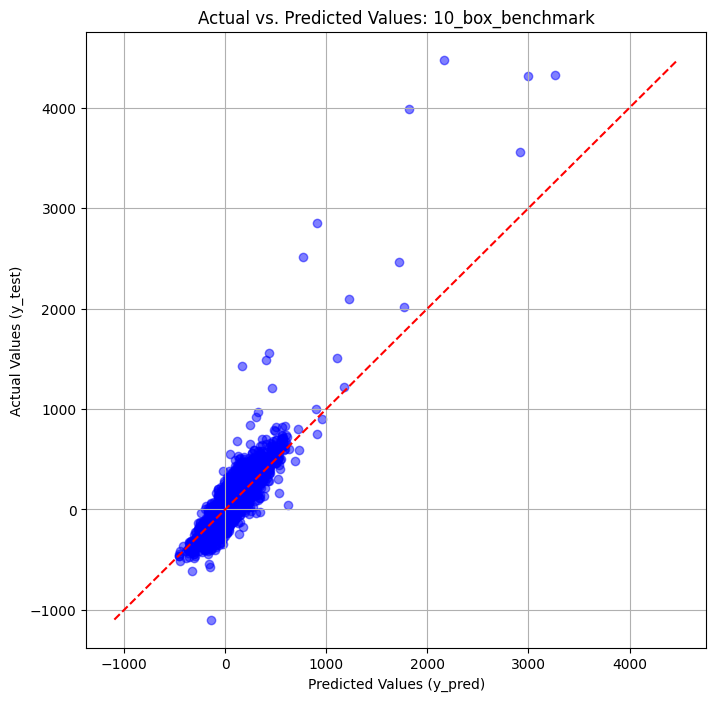

In [13]:

# Create a scatter plot
plt.figure(figsize=(8, 8))
plt.scatter(y_pred, y_test, alpha=0.5, color='b')
# Plot a line for perfect predictions
plt.plot([min(y_test), max(y_test)], [min(y_test), max(y_test)], color='r', linestyle='--')

# Add labels and title
plt.xlabel('Predicted Values (y_pred)')
plt.ylabel('Actual Values (y_test)')
plt.title('Actual vs. Predicted Values: 10_box_benchmark')

# Show the plot
plt.grid(True)
plt.show()




---



# Outside/Inside Test Set Evaluation
Previous testing was on values within the trianing region. This section tests the model accuracy on data from a distant region. This serves as a way of quantifying spatial importance for this model.

Results are also plotted against the true values of the training data, which is a less accurate measure of accuracy due to overfitting. The motivation of this plotting is to see how well the model captured spatial data in the region.

In [52]:
import xarray as xr
import matplotlib.pyplot as plt

plot_df = pd.read_csv('/content/1_box_benchmark.csv')
plot_df.head()

,Unnamed: 0,Longitude,Latitude,EMAG2v3,igrf_dec,interpolated_bouguer,cm_curie_point_depth,wgm2012_freeair_ponc,rayleigh_group,gl_elevation,love_phase,sc_crust_den
0,0,-114.960,33.012241,-50.082520,13.055014,113.541812,22.402573,-8.474015,3.608761,219.32018,4.409144,2840.9907
1,1,-114.864,33.012241,-53.503196,13.034248,107.595516,22.492798,-10.750948,3.607108,262.22073,4.409158,2848.3438
2,2,-114.768,33.012241,-43.275106,13.013350,100.804905,22.552032,-12.094639,3.605564,311.12128,4.409266,2844.4673
3,3,-114.672,33.012241,-35.013360,12.992318,100.903579,22.575600,-33.720554,3.603498,133.24623,4.409333,2824.9540
4,4,-114.576,33.012241,-36.535661,12.971152,103.915919,22.564999,-28.813229,3.601716,136.99182,4.409021,2823.3890


In [53]:

# Columns to exclude
exclude_columns = ['Longitude', 'Latitude', 'EMAG2v3','points','Distance_to_Coast']

# Select columns not in exclude_columns using boolean indexing
X = plot_df.loc[:, ~plot_df.columns.isin(exclude_columns)]

X = X.fillna(X.median())

# Normalize the features
scaler = preprocessing.StandardScaler()
X = scaler.fit_transform(X)

# Predict on test data
y_pred = rf_model.predict(X)
y_test = plot_df['EMAG2v3'].fillna(plot_df['EMAG2v3'].median())
evaluate_model(y_test, y_pred)

outside_test_df = plot_df[['Longitude', 'Latitude']].copy()
outside_test_df['y_pred'] = y_pred
outside_test_df['y_test'] = y_test
outside_test_df

Mean Squared Error: 27176.594178329527
R² Score: -0.08227882291219957
Root Mean Squared Error: 164.85325043301248
Mean Absolute Error: 122.4371357410389
Coefficient of Variation of RMSE: 1.040326305979138


,Longitude,Latitude,y_pred,y_test
0,-114.960,33.012241,-2.416730,-50.082520
1,-114.864,33.012241,-2.833631,-53.503196
2,-114.768,33.012241,-0.361768,-43.275106
3,-114.672,33.012241,35.274699,-35.013360
4,-114.576,33.012241,23.578122,-36.535661
...,...,...,...,...
36292,-83.472,42.920926,114.658825,29.442727
36293,-83.376,42.920926,202.745724,52.219273
36294,-83.280,42.920926,60.193417,38.948523
36295,-83.184,42.920926,65.377433,-47.958549


### Graphs Comparing Predicted Data to Actual Data

The plots below display both the model's predicted values (top plot) and the actual recorded values (bottom plot) for the same geographic region.

### Plot Attributes

- **Axes**: Longitude (x-axis) and Latitude (y-axis).
- **Color Scale**: Represents the magnitude of values.
  - **Predicted Data**: Ranges from approximately -300 to 100.
  - **Actual Data**: Ranges from approximately -400 to 400.
- **Colors**:
  - **Red**: Indicates higher values.
  - **Blue**: Indicates lower values.

### Analysis

- **Comparison**: Visually compare the spatial patterns and color distributions.
- **Ideal Outcome**: Predicted data should closely resemble actual data.
- **Discrepancies**: Highlight areas where the model's predictions differ from actual values, indicating the need for model adjustments or additional features.

These plots provide a quick visual assessment of the model's accuracy and highlight areas for potential improvement.

In [60]:
# Pivot the DataFrame
def dataframe_to_grid_plot(df):
  for result in ['y_pred','y_test']:
    pivot_df = outside_test_df.pivot(index='Longitude', columns='Latitude', values= result)

    data_array = xr.DataArray(pivot_df.values, coords=[pivot_df.index, pivot_df.columns],
                                          dims=['Longitude', 'Latitude'])
    data_array.plot(vmin = -400, vmax = 400, cmap='RdBu_r', figsize=(10, 10))
    plt.title(f'{result} Values')
    plt.xlabel('Longitude')
    plt.ylabel('Latitude')
    plt.show()

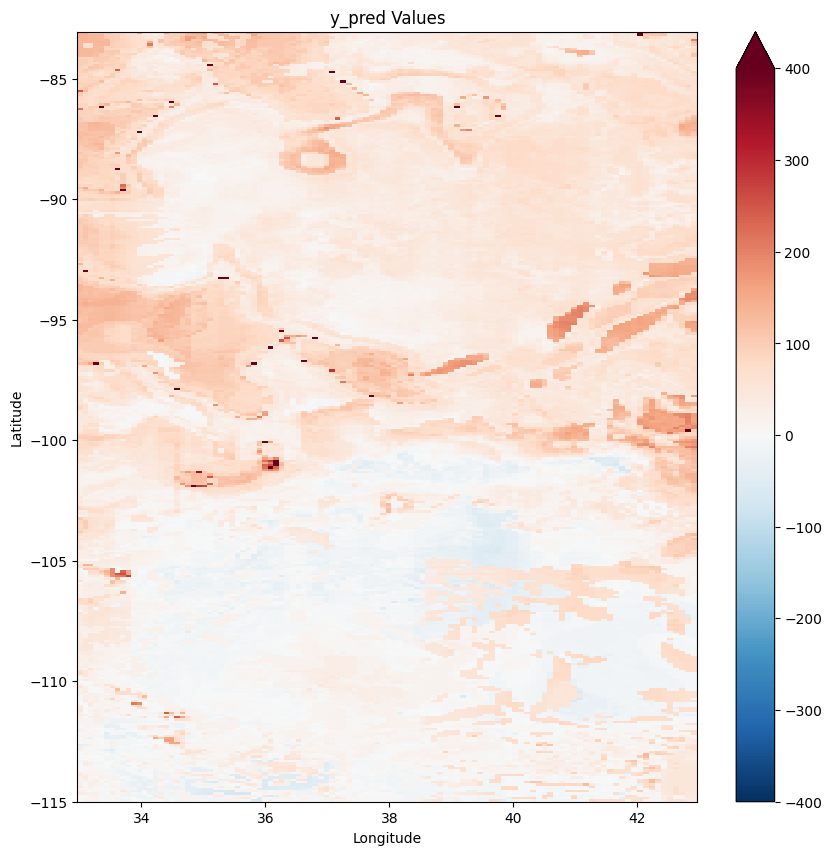

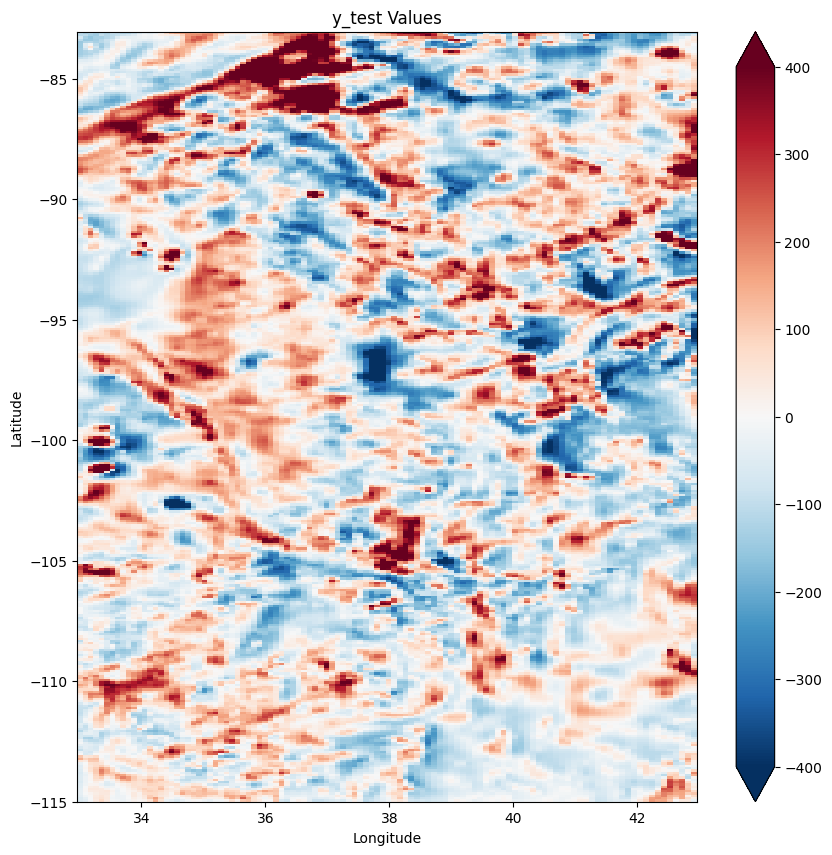

In [61]:
dataframe_to_grid_plot(outside_test_df)